# Auswertung Dynamische Filmschichtdicke

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.signal import medfilt2d
from scipy.fft import rfft, rfftfreq
import matplotlib.animation as animation

In [3]:
alpha = 20
nameString = f"grosseLoecher_{alpha}grad"
frame = 600
vdot = 2.042 #1.212    l/min
diameterHoles = 5.7 #4   mm

In [4]:
# using slope fit parameters with fixed origin 

def calculateThickness(relativeIntensity, fitSlope = -2.17, fitIntercept = 0):

    if type(relativeIntensity) is np.ndarray:
        thickness = np.zeros_like(relativeIntensity)
        thickness[relativeIntensity > 0] = fitSlope*np.log(relativeIntensity[relativeIntensity > 0]) + fitIntercept
    else:
        thickness = fitSlope*np.log(relativeIntensity) + fitIntercept

    return thickness

smoothing = lambda values: medfilt2d(values, (11, 11))

In [5]:
# import data, divide background

ohnePlatte = np.load("./frames/hintergrund_ohnePlatte.npy")

def getData(nameString):
    return (np.load("./frames/" + nameString + ".npy")/ohnePlatte).astype("float32")

def getThickness(nameString, frameStart = 0, frameStop = 1200, frameStep = 100, centervalue = False):
    if centervalue:
        data = getData(nameString)[frameStart:frameStop:frameStep,423:427,423:427]
        thicknessArray = np.zeros(data.shape[0])
    else:
        data = getData(nameString)[frameStart:frameStop:frameStep]
        thicknessArray = np.zeros_like(data)

    
    for i, frame in enumerate(data):
        if centervalue:
            thicknessArray[i] = calculateThickness(frame).mean()
        else:
            thicknessArray[i] = calculateThickness(smoothing(frame))
    return thicknessArray

Text(0.5, 1.0, '  saw tooth dam,   $\\dot V$ = 1.21 l/min,   $\\alpha$ = 20°,   Frame 600,   $\\bar f_s$ = 0.339 mm,   $\\sigma_s$ = 0.12 mm \n')

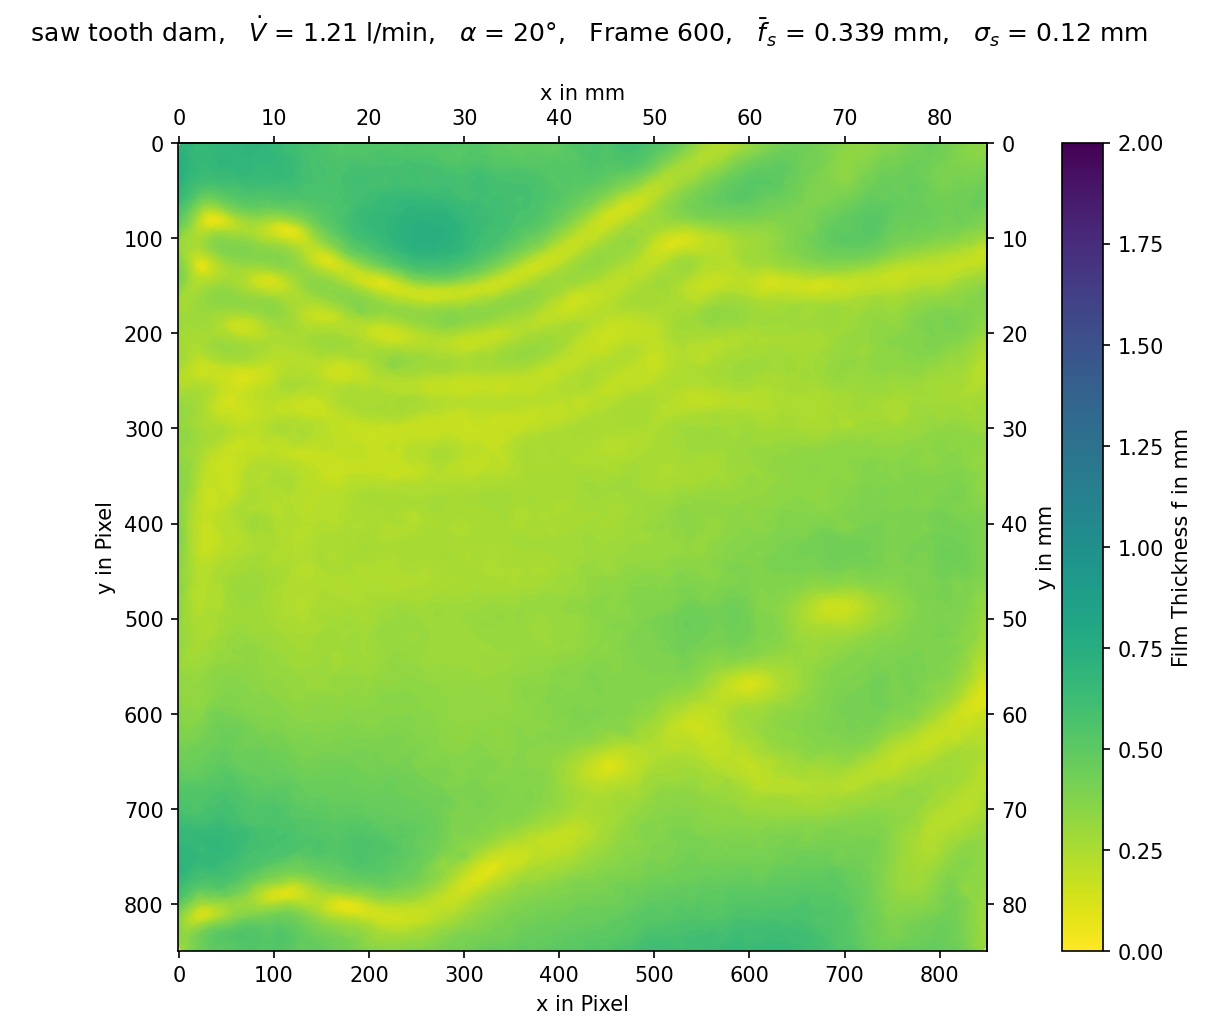

In [52]:
# plot dynamic film thickness

image = getThickness(nameString, frame, frame+1)[0]

fig, ax = plt.subplots(1, 1, dpi = 150, figsize = (13,7))
plot1 = ax.imshow(image, vmin = 0, vmax = 2, cmap = "viridis_r")
ax.set_xlabel("x in Pixel")
ax.set_ylabel("y in Pixel")
cbar = fig.colorbar(plot1)
cbar.set_label("Film Thickness f in mm")

secax = ax.secondary_xaxis("top", functions = (lambda x1: x1/10, lambda x2: x2*10))
secax.set_xlabel("x in mm")
secay = ax.secondary_yaxis("right", functions = (lambda x1: x1/10, lambda x2: x2*10))
secay.set_ylabel("y in mm")

#ax.set_title(f"  d = {diameterHoles} mm,   $\dot V$ = {vdot:.2f} l/min,   $\\alpha$ = {alpha}°,   Frame {frame},   $\\bar f_s$ = {image.mean():.3f} mm,   $\\sigma_f$ = {image.std():.2} mm \n")
ax.set_title(f"  saw tooth dam,   $\dot V$ = {vdot:.2f} l/min,   $\\alpha$ = {alpha}°,   Frame {frame},   $\\bar f_s$ = {image.mean():.3f} mm,   $\\sigma_s$ = {image.std():.2} mm \n")

#image.mean(), image.std(), image.min(), image.max()

In [69]:
fig.savefig("./plots/" + nameString + ".png", bbox_inches = "tight")

In [87]:
def getDominantFequency(mag, freq):
    localMax = 0
    for i, val in enumerate(mag):
        if val > localMax:
            localMax = val
            maxIndex = i
    return freq[maxIndex]

Text(0, 0.5, 'Magnitude in arb. units')

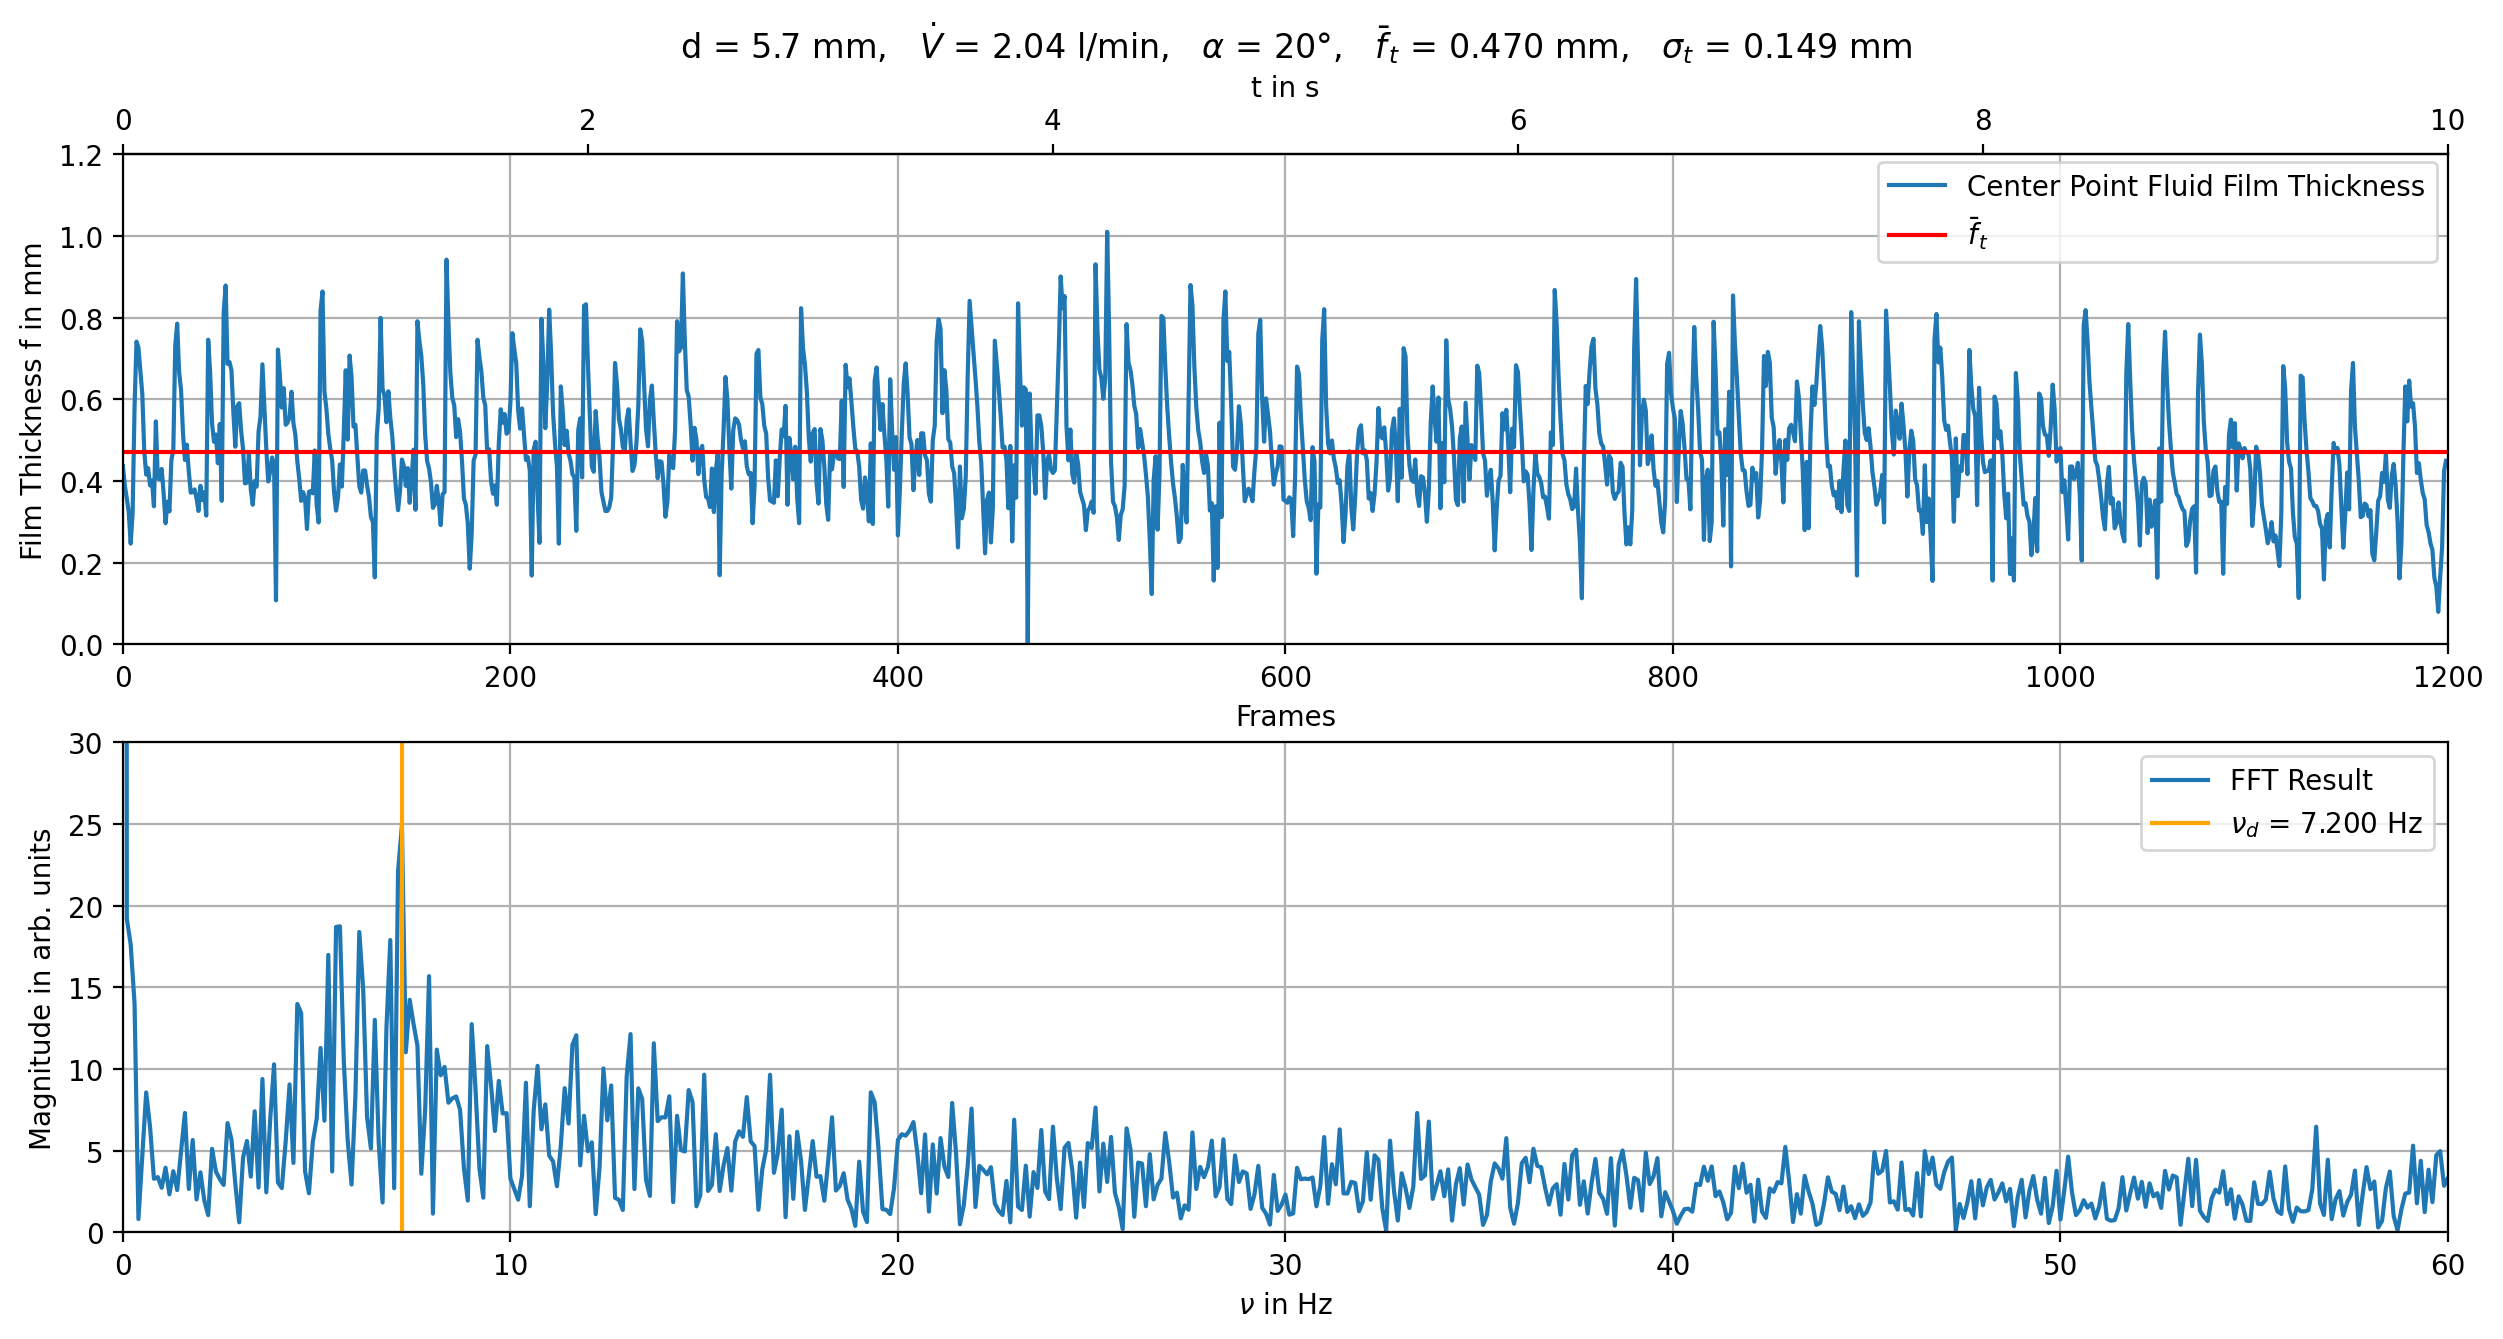

In [101]:
# plot thickness at one spot (400, 400)

centerThickness = getThickness(nameString, 0, 1200, 1, centervalue=True)

fig, ax = plt.subplots(2, 1, dpi = 200, figsize = (15, 7))
ax[0].plot(centerThickness, label = "Center Point Fluid Film Thickness")
ax[0].set_xlim(0, 1200)
ax[0].set_xlabel("Frames")
ax[0].set_ylabel("Film Thickness f in mm")
secax = ax[0].secondary_xaxis("top", functions = (lambda x1: x1/120, lambda x2: x2*120))
secax.set_xlabel("t in s")
ax[0].grid()
ax[0].axhline(centerThickness.mean(), color = "red", linestyle = "-", label = f"$\\bar f_t$")
ax[0].legend(loc=(0.755, 0.78))
ax[0].set_ylim(0.0, 1.2)

ax[0].set_title(f"  d = {diameterHoles} mm,   $\dot V$ = {vdot:.2f} l/min,   $\\alpha$ = {alpha}°,   $\\bar f_t$ = {centerThickness.mean():.3f} mm,   $\sigma_t$ = {centerThickness.std():.3f} mm")

dftResult = rfft(centerThickness, 1200)
dftFreq = rfftfreq(1200, 1/120)
domFreq = getDominantFequency(np.abs(dftResult).real[3:], np.abs(dftFreq)[3:])
ax[1].plot(dftFreq, np.abs(dftResult), label = "FFT Result")
ax[1].set_xlim(0, 60)
ax[1].set_ylim(0, 30)
ax[1].grid()
ax[1].axvline(domFreq, color = "orange", label = f"$\\nu_d$ = {domFreq:.3f} Hz")
ax[1].legend()
ax[1].set_xlabel("$\\nu$ in Hz")
ax[1].set_ylabel("Magnitude in arb. units")

In [102]:
fig.savefig("./plots/" + nameString + "_fourier.png", bbox_inches = "tight")

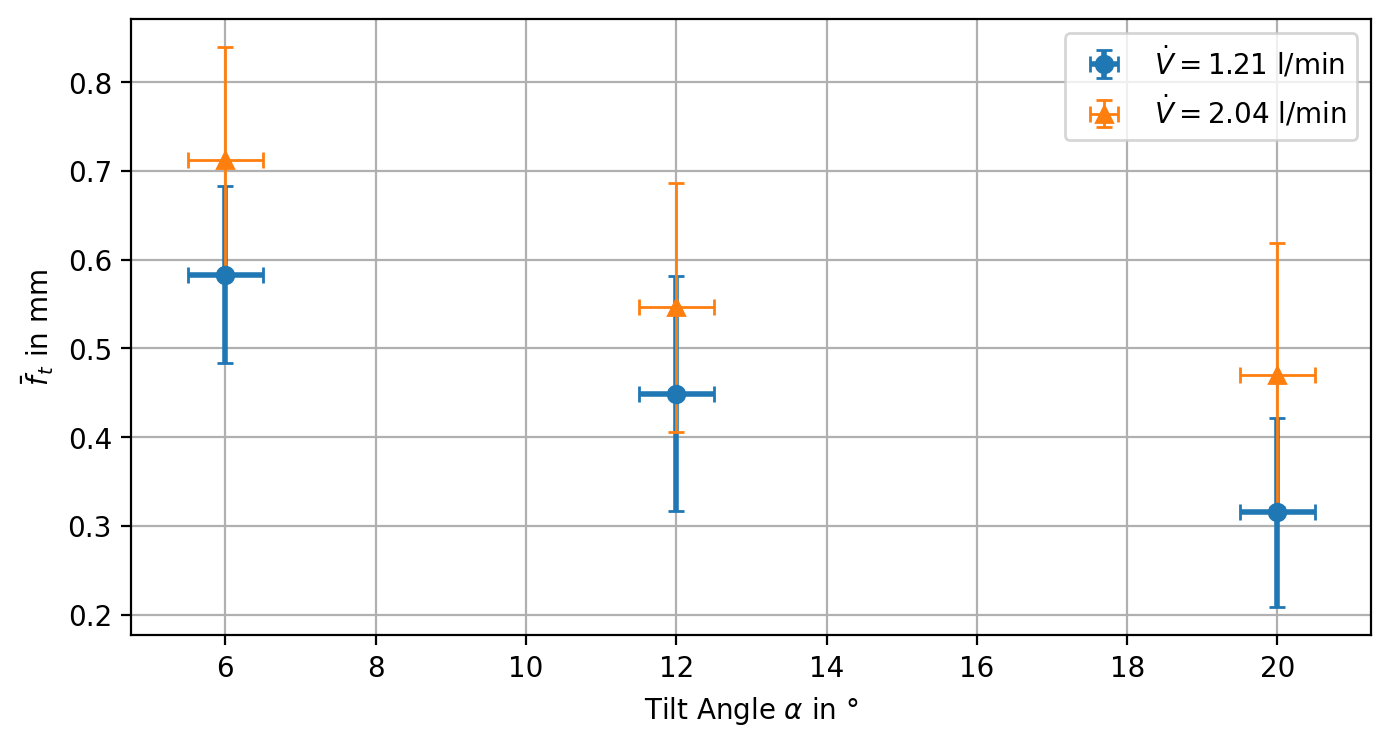

In [2]:
# Comparison Plots of Thickness vs Angle vs Volumetric Flow

angles = [6, 12, 20] #degrees
errAngles = [0.5, 0.5, 0.5]
thicknessV1 = [0.583, 0.449, 0.315]
errThicknessV1 = [0.1, 0.132, 0.107]
thicknessV2 = [0.712, 0.546, 0.470]
errThicknessV2 = [0.127, 0.14, 0.149]

fig, ax = plt.subplots(1, 1, dpi = 200, figsize = (8, 4))
ax.errorbar(angles, thicknessV1 , xerr = errAngles, yerr = errThicknessV1, marker="o", linewidth=0, elinewidth=2, capsize=3, label = "$\dot V = 1.21$ l/min")
ax.errorbar(angles, thicknessV2 , xerr = errAngles, yerr = errThicknessV2, marker="^", linewidth=0, elinewidth=1, capsize=3, label = "$\dot V = 2.04$ l/min")
ax.set_ylabel("$\\bar f_t$ in mm")
ax.set_xlabel("Tilt Angle $\\alpha$ in °")
ax.legend()
ax.grid()

In [3]:
fig.savefig("./plots/thickness_comparison.png", bbox_inches = "tight")

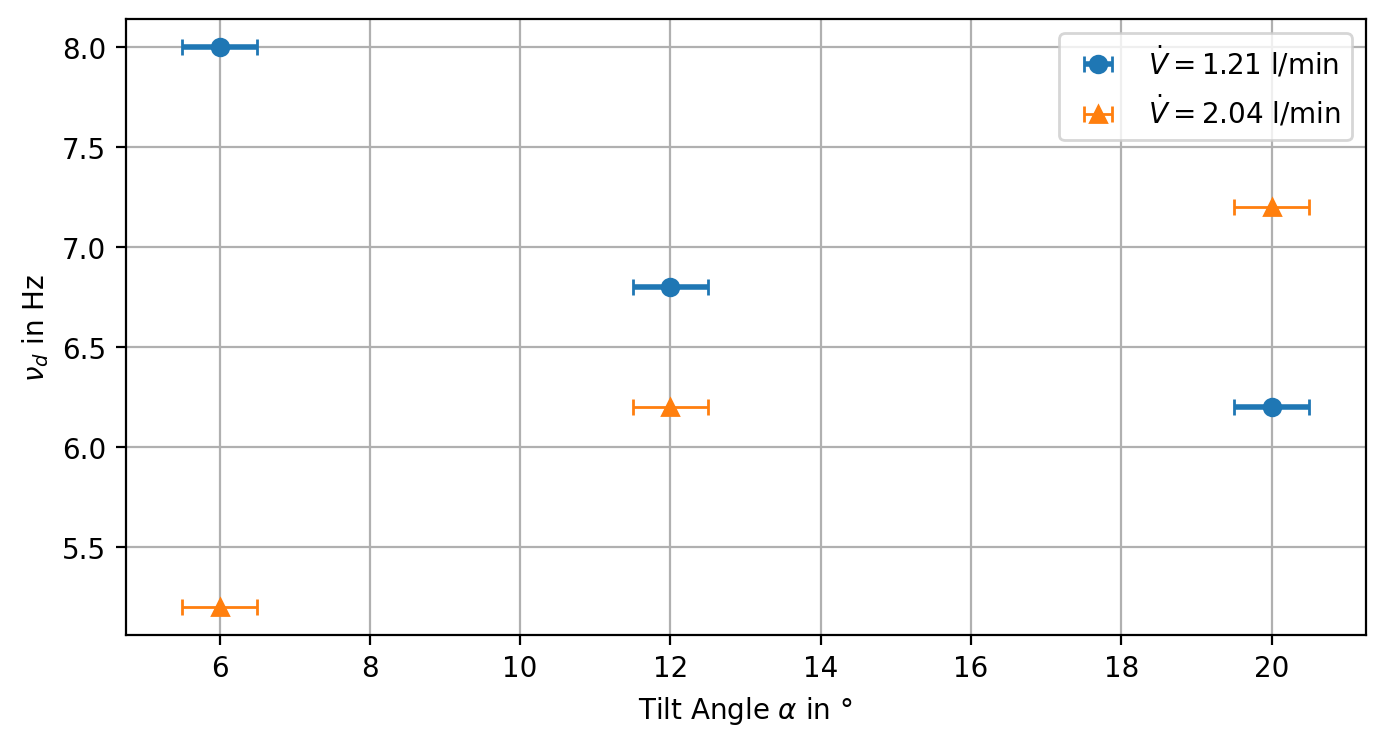

In [4]:
# Comparison Plots of Frequency vs Angle vs Volumetric Flow

angles = [6, 12, 20] #degrees
errAngles = [0.5, 0.5, 0.5]
freqV1 = [8, 6.8, 6.2]
freqV2 = [5.2, 6.2, 7.2]

fig, ax = plt.subplots(1, 1, dpi = 200, figsize = (8, 4))
ax.errorbar(angles, freqV1, xerr = errAngles, capsize = 3, marker = "o", linewidth = 0, elinewidth = 2, label = "$\dot V = 1.21$ l/min")
ax.errorbar(angles, freqV2, xerr = errAngles, capsize = 3, marker = "^", linewidth = 0, elinewidth = 1, label = "$\dot V = 2.04$ l/min")
ax.set_ylabel("$\\nu_d$ in Hz")
ax.set_xlabel("Tilt Angle $ \\alpha$ in °")
ax.legend()
ax.grid()

In [5]:
fig.savefig("./plots/frequency_comparison.png", bbox_inches = "tight")

In [ ]:
# plot animations

fig, ax = plt.subplots(1, 1, dpi = 300, figsize = (6,5))
imshow = ax.imshow(image, vmin = 0, vmax = 4,  cmap = "hot", animated = True)
fig.colorbar(plot1)

def update(frame):
    # for each frame, update the data stored on each artist.
    image = (calculateThickness(dynTest03[frame, :, :])
    # update the plot:
    imshow.set_data(image)
    return plot1


ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()

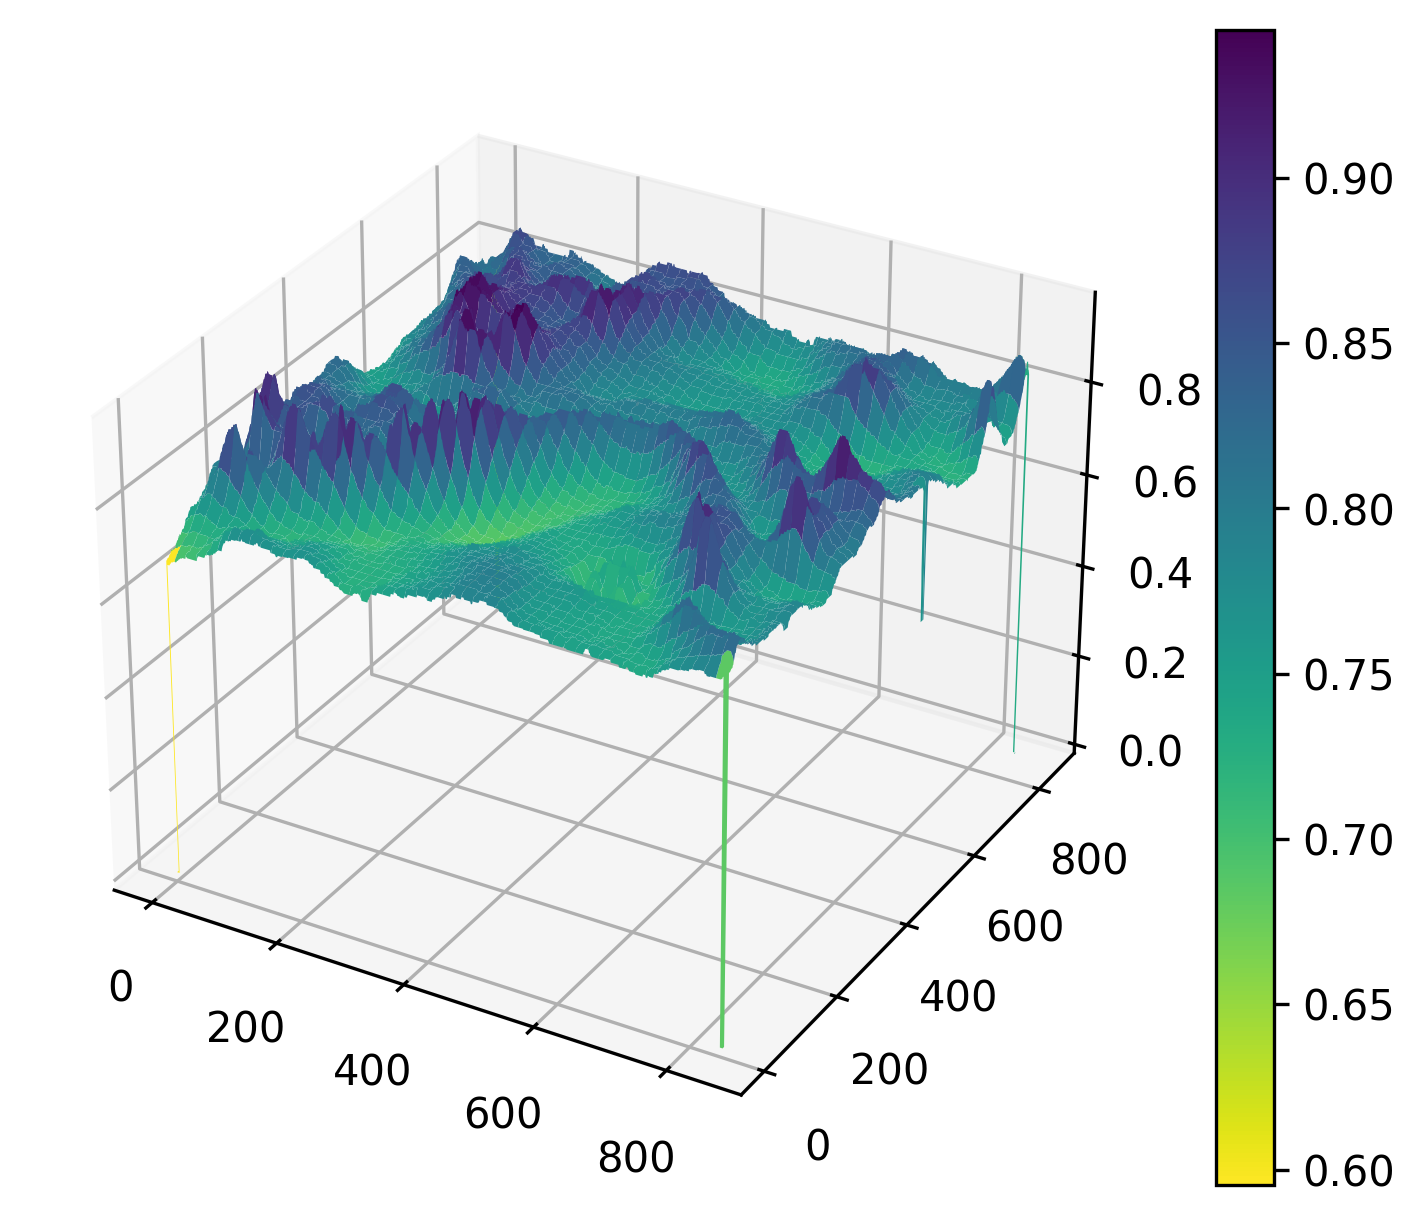

In [5]:
# 3d surface plot

from scipy.signal import medfilt2d

getFrame = lambda i: medfilt2d(np.load("./frames/grosseLoecher_20grad.npy")[i]/ohnePlatte, (11, 11))

fig, ax = plt.subplots(1, 1, dpi = 300, figsize = (6,5), subplot_kw={"projection": "3d"})

x = np.arange(0, 850)
X, Y = np.meshgrid(x, x)
im = ax.plot_surface(X, Y, getFrame(200), cmap = "viridis_r")
#ax.set_zlim(0.2, 0.4)
fig.colorbar(im)